# Imports and prepare data for visualization

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import skimage
from skimage import io
from PIL import Image

import copy
import os
import glob

from gnomon import husk

In [2]:

## full_data includes the dataset with photo information, datetime, location, etc.
data = pd.read_csv(os.path.join("data", "gnomon_data.csv"))
data["Datetime"] = pd.to_datetime(data["Datetime"])


In [5]:
# Create a husk object and read in all images from the week

husky = husk()

for i in data.index.values:
    husky.add_image(filename = data.loc[i, 'Image filename'])

husky.rotate_all('r')

husky.blend()

# %matplotlib inline
# husky.show_comp()

Picture resolutions are not identical. Resizing images...


/opt/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Images resized.


In [6]:

def av_time(df, cluster_n):
    """
    Finds the average time of a cluster and returns it as a string
    """
    # Create a working dataframe with only the cluster you're looking at
    ## Cluster 0 means all clusters
    if cluster_n == 0: 
        workingdf = copy.copy(df)
    else:
        workingdf = df[df['Cluster'] == cluster_n]
    
    # Create new columns for Hour and Minute features from the datetime
    workingdf['Hour'] = workingdf['Datetime'].apply(lambda dt: dt.hour)
    workingdf['Minute'] = workingdf['Datetime'].apply(lambda dt: dt.minute)
    workingdf['time_in_min'] = (workingdf['Hour']) * 60 + workingdf['Minute']
    
    av = workingdf['time_in_min'].mean()
        
    return "%d:%d" % (av//60, av%60)


In [7]:
av_time(data, 5)

/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.or

'16:26'

# Histograms


In [8]:
# A function to prepare the data for creating a stacked bar chart of pixel
# lightness or darkness by time of day

def make_xy(df, cluster_n, imgs, nbins=20):
    """
    Takes a dataframe (with datetime stamp of each photo), a cluster number,
    a set of images, and the number of bins to create and returns x positions 
    and y lengths for stacked bar charts.
    """
    # Create a working dataframe with only the cluster you're looking at
    ## Cluster 0 means all clusters
    if cluster_n == 0: 
        workingdf = copy.copy(df)
    else:
        workingdf = df[df['Cluster'] == cluster_n]
    
    # Create new columns for Hour and Minute features from the datetime
    workingdf['Hour'] = workingdf['Datetime'].apply(lambda dt: dt.hour)
    workingdf['Minute'] = workingdf['Datetime'].apply(lambda dt: dt.minute)
    workingdf['min_past_7'] = (workingdf['Hour'] - 7) * 60 + workingdf['Minute']
    
    # Sort the dataframe by (1) minute, then by (2) hour
    workingdf = workingdf.sort_values(by="min_past_7")
    
    # Find the first bar in the set (nearest multiple of 12 less than first #)
    bar_1 = workingdf.iloc[0]['min_past_7']
    while bar_1 % 12:
        bar_1 -= 1
        
    # Find the last bar in the set (nearest multiple of 12 greater than first #)
    bar_n = workingdf.iloc[-1]['min_past_7']
    while bar_n % 12:
        bar_n += 1
    
    # Find the number of bars by the distance between the first and last photos
    # One bar will represent 12 minutes, so there are 5 bars per hour
    n_bars = (bar_n - bar_1) / 12
    
    # Initialize two arrays of zeros of the proportions n_bars x n_bins
    xs = np.zeros((nbins, int(n_bars)), dtype=int)
    ys = np.zeros((nbins, int(n_bars)), dtype=int)
    # Initialize one array to be used for positioning of bar on the dial
    bar_begs = np.zeros(int(n_bars), dtype=int)
    
    next_bar = copy.copy(bar_1)
    i = 0
    
    for n in range(int(n_bars)):
        next_bar += 12
        bar_begs[n] = next_bar # Store the end position of the bar
        
        # Find all photos that belong in the current bar and add their bin values
        while ((i < len(workingdf.index.values)) and (workingdf.iloc[i]['min_past_7'] < next_bar)):
            img_gray = skimage.color.rgb2gray(imgs[workingdf.index.values[i]])
            y, x = skimage.exposure.histogram(img_gray.flatten(), nbins=nbins)
        
            for j in range(nbins):
                xs[j][n] += x[j]
                ys[j][n] += y[j]
                
            i+=1
        
    return xs, ys, bar_begs


# Make the dial charts

In [9]:
nbins = 10
cluster = 0

x, y, bar_begs = make_xy(data, cluster, husky.imgs, nbins=nbins)

/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-

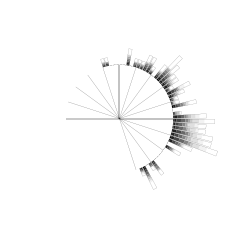

In [15]:

# def dialChart(cluster, nbins):

nbins = 10
cluster = 5
    
x, y, bar_begs = make_xy(data, cluster, husky.imgs, nbins=nbins)

# One hour on the dial is represented by Pi / 10 degrees

N = len(data[data['Cluster'] == cluster])
bottom = 8_000_000
width = np.pi / 50 # Each bar represents one fifth of an hour
radial_bar_begs = (bar_begs // 12) * (np.pi / 50) - (width / 2) # Position of bars on radial dial

# Set color map for the image
cmap = matplotlib.cm.get_cmap('Greys_r')
#     cmap = matplotlib.cm.get_cmap('viridis')
col_vals = np.linspace(0.0, 1.0, num=len(x), endpoint=True) # Determines the hue for each level of the stacked bar

ax = plt.subplot(111, projection='polar')
# rad_beg = np.linspace((np.pi*3/11), 13*np.pi / 11, N, endpoint=True)

bottoms = np.zeros(len(x[0])) + bottom

for i in range(len(x)):
    ax.bar(radial_bar_begs, y[i], width=0.05, bottom=bottoms,
           color=cmap(col_vals[i]), edgecolor='black', linewidth=0.000, 
           alpha=1.0)
    bottoms += y[i]
    
# Add a border around the entire bar
borderBar = np.zeros(shape=y.shape[1])
for i in range(y.shape[0]):
    borderBar += y[i]
ax.bar(radial_bar_begs, borderBar, width=0.05, bottom=bottom, fill=False, edgecolor='black', linewidth=0.1)

linealpha = .9
linewidth = 0.2
# ax.axhline(1, alpha=linealpha, linewidth=linewidth, color='black')
plt.vlines(0, ymin=0, ymax=bottom, alpha=1, linewidth=linewidth+.09, color='black')
plt.vlines(np.pi/2, ymin=0, ymax=bottom, alpha=1, linewidth=linewidth+.15, color='black')
plt.vlines(np.pi, ymin=0, ymax=bottom, alpha=1, linewidth=linewidth+.15, color='black')

hours = 0
while hours <= (16*np.pi / 11):
    plt.vlines(hours, ymin=0, ymax=bottom, alpha=linealpha-.2, linewidth=linewidth, color='black')
    hours += np.pi/10


ax.set_theta_zero_location('W')
ax.set_theta_direction(-1)
plt.xticks([])
plt.yticks([])
ax.spines['polar'].set_visible(False)
# plt.show()

# Save the graphic
path = os.path.join("dial_graphs", "dial_graph_%dbins_%d.png" % (nbins, cluster))
plt.savefig(path, dpi=1200, format='png', transparent=True)
    